In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Load data sets
(x_train_all, y_train_all), (x_test, y_test)= tf.keras.datasets.imdb.load_data(skip_top=20, num_words=100)


skip top은 건너뛸 단어의 개수 지정
num_word : 훈련에 사용될 단어 수 

In [20]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [21]:
# bag of word
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [22]:
# except 0, 1, 2
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w>2]

print(x_train_all[0])

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [23]:
# down load word index
word_to_index = tf.keras.datasets.imdb.get_word_index()
word_to_index['movie']

17

In [24]:
# 훈련셋을 영단어로 변환
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w-3], end=' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [25]:
print(len(x_train_all[0]), len(x_train_all[1]))
# 샘플의 길이가 다르다

59 32


In [0]:
# divide sample
np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [0]:
# sample length fitting
maxlen = 100
x_train_seq = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
y_val_seq = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

In [0]:
# sample one-hot-encoding
x_train_onehot = tf.keras.utils.to_categorical(x_train_seq)
x_val_onehot = tf.keras.utils.to_categorical(y_val_seq)

In [0]:
# 원핫 인코딩은 많은 데이터를 필요로 한다. 

# 순환 신경망
class RNN:
    def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
        self.n_cells = n_cells          # 셀 개수
        self.batch_size = batch_size    # 배치 사이즈
        self.w1h = None                 # 은닉 상태 가중치
        self.w1x = None                 # 입력에 대한 가중치
        self.b1 = None
        self.w2 = None                  # 출력층 가중치와 절편
        self.b2 = None
        self.h = None                   # 순환층의 activation을 거친 후의 출력
        self.losses = []  # 훈련 손실
        self.val_losses = []  # 검증 손실
        self.lr = learning_rate

    def forpass(self, x):
        self.h = [np.zeros((x.shape[0], self.n_cells))]  # 은닉 상태 초기화
        seq = np.swapaxes(x, 0, 1)  # 배치 차원과 스텝 차원을 바꾸기
        for z in seq:
            z1 = np.dot(z, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
            h = np.tanh(z1)  # activation func가 하이퍼볼릭 탄젠트
            self.h.append(h) # 역전파를 위해 은닉 상태를 저장
            z2 = np.dot(h, self.w2) + self.b2
        return z2

    def backprop(self, x, err):
        m = len(x)  # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그라디언트 계산
        w2_grad = np.dot(self.h[-1].T, err) / m
        b2_grad = np.sum(err)/ m
        # 배치 차원과 타임 스텝 차원을 바꿈
        seq = np.swapaxes(x, 0, 1)
        w1h_grad = w1x_grad = b1_grad = 0
        # 셀 직전까지의 에러 계산
        err_to_cell = np.dot(err, self.w2.T) * (1-self.h[-1]**2)
        # 모든 타임스텝을 거슬러 가면서 그라디언트를 역전파
        for x, h in zip(seq[::1][:10], self.h[:-1][::-1][:10]):
            w1h_grad += np.dot(h.T, err_to_cell)
            w1x_grad += np.dot(x.T, err_to_cell)
            b1_grad += np.sum(err_to_cell, axis=0)
            err_to_cell = np.dot(err_to_cell, self.w1h)*(1-h**2)

        w1h_grad /= m
        w1x_grad /= m
        b1_grad /= m

        return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad

    def sigmoid(self, z):
        a = 1 / (1 + np.exp(-z))
        return a
        
    def init_weight(self, n_features, n_classes):
        # initialize weight
        orth = tf.initializers.Orthogonal()
        glorot = tf.initializers.GlorotUniform()

        self.w1h = orth((self.n_cells, self.n_cells)).numpy()
        self.w1x = glorot((n_features, self.n_cells)).numpy()
        self.b1 = np.zeros(self.n_cells)
        self.w2 = glorot((self.n_cells, n_classes)).numpy()
        self.b2 = np.zeros(n_classes)

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1,1)
        y_val = y_val.reshape(-1,1)
        np.random.seed(42)
        self.init_weight(x.shape[2], y.shape[1])  # 은닉층과 출력층 가중치 초기화
        for i in range(epochs):
            print("Epochs", end=' ')  # 제너레이터에서 반환한 미니배치 순환
            batch_losses = []
            for x_batch, y_batch in self.get_batch(x,y):
                print('.', end=' ')
                a = self.training(x_batch, y_batch)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss = np.mean(-(y_batch * np.log(a) + (1-y_batch) * np.log(1-a)))
                batch_losses.append(loss)
            print( )
            self.losses.append(np.mean(batch_losses))
            self.update_val_loss(x_val, y_val)

    def get_batch(self, x, y):
        # generator 함수
        length = len(x)
        bins = length // self.batch_size  # 미니 배치 횟수
        if length % self.batch_size:
            bins += 1  # 나누어 떨어지지 않는경우
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i+1)
            yield x[start:end], y[start:end]

    def training(self, x, y):
        m = len(x)
        z = self.forpass(x)
        a = self.sigmoid(z)
        err = -(y - a)
        w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        self.w1h -= self.lr * w1h_grad
        self.w1x -= self.lr * w1x_grad
        self.b1 -= self.lr * b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a

    def predict(self, x):
        z = self.forpass(x)
        return z > 0  # 스텝함수 적용

    def score(self, x, y ):
        return np.mean(self.predict(x) == y.reshape(-1,1))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.sigmoid(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.mean(-(y_val * np.log(a) + (1-y_val) * np.log(1-a)))
        self.val_losses.append(val_loss)

In [35]:
rnn = RNN(n_cells=32, batch_size=32, learning_rate=0.01)
rnn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val=y_val)

Epochs . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [40]:
# tensorflow 로 RNN 만들기
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(32, input_shape=(100,100)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                4256      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


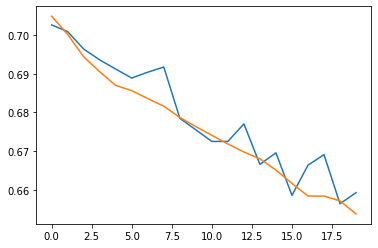

In [37]:
plt.plot(rnn.val_losses)
plt.plot(rnn.losses)

In [39]:
rnn.score(x_val_onehot, y_val)

0.6056

In [41]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# 기록
his = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, validation_data=(x_val_onehot, y_val))

Epoch 1/20
625/625 [==============================] - 11s 17ms/step - loss: 0.6975 - accuracy: 0.5234 - val_loss: 0.6920 - val_accuracy: 0.5336
Epoch 2/20
625/625 [==============================] - 10s 17ms/step - loss: 0.6795 - accuracy: 0.5688 - val_loss: 0.6666 - val_accuracy: 0.5992
Epoch 3/20
625/625 [==============================] - 10s 17ms/step - loss: 0.6683 - accuracy: 0.5879 - val_loss: 0.6693 - val_accuracy: 0.5814
Epoch 4/20
625/625 [==============================] - 10s 17ms/step - loss: 0.6532 - accuracy: 0.6151 - val_loss: 0.6496 - val_accuracy: 0.6180
Epoch 5/20
625/625 [==============================] - 10s 17ms/step - loss: 0.6366 - accuracy: 0.6385 - val_loss: 0.6208 - val_accuracy: 0.6538
Epoch 6/20
625/625 [==============================] - 10s 17ms/step - loss: 0.6173 - accuracy: 0.6608 - val_loss: 0.6247 - val_accuracy: 0.6540
Epoch 7/20
625/625 [==============================] - 10s 17ms/step - loss: 0.6077 - accuracy: 0.6734 - val_loss: 0.6176 - val_accuracy:

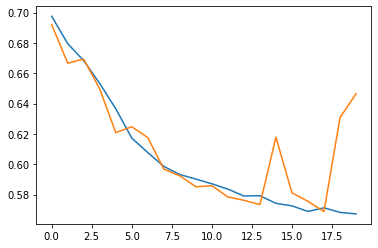

In [42]:
#훈련셋, 검증셋의 손실그래프와 정확도 그리기
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])

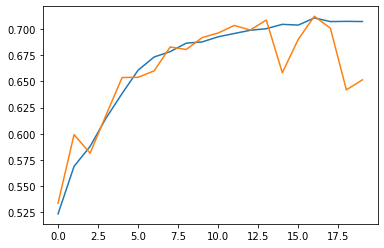

In [43]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])

In [44]:
# 단어 임베딩

embed = tf.keras.models.Sequential()
embed.add(tf.keras.layers.Embedding(1000,32))
embed.add(tf.keras.layers.SimpleRNN(8))
embed.add(tf.keras.layers.Dense(1, activation='sigmoid'))

embed.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 328       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


In [45]:
x_val_seq = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

embed.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = embed.fit(x_train_seq, y_train, epochs=10, batch_size=32, validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 11s 18ms/step - loss: 0.6426 - accuracy: 0.6173 - val_loss: 0.5956 - val_accuracy: 0.6846
Epoch 2/10
625/625 [==============================] - 11s 18ms/step - loss: 0.5826 - accuracy: 0.6967 - val_loss: 0.5847 - val_accuracy: 0.6952
Epoch 3/10
625/625 [==============================] - 11s 18ms/step - loss: 0.5760 - accuracy: 0.7001 - val_loss: 0.6034 - val_accuracy: 0.6772
Epoch 4/10
625/625 [==============================] - 12s 18ms/step - loss: 0.5652 - accuracy: 0.7131 - val_loss: 0.5709 - val_accuracy: 0.7058
Epoch 5/10
625/625 [==============================] - 12s 19ms/step - loss: 0.5566 - accuracy: 0.7156 - val_loss: 0.5789 - val_accuracy: 0.7028
Epoch 6/10
625/625 [==============================] - 12s 19ms/step - loss: 0.5515 - accuracy: 0.7225 - val_loss: 0.5681 - val_accuracy: 0.7062
Epoch 7/10
625/625 [==============================] - 12s 19ms/step - loss: 0.5486 - accuracy: 0.7200 - val_loss: 0.5657 - val_accuracy:

In [0]:
#LSTM(8), Dense(1, sigmoid)를 하면 LSTM완성!